In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = ''

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

sig_100000_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_bas_data_nor_b25_targets_t1_nat_k5_b25_t1_0_42_n_nat_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(878801, 834)
(878801, 3)
validation
(151459, 834)
(151459, 3)
test
(112754, 834)
(112754, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 834)]             0         


 dense (Dense)               (None, 2048)              1710080   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 3)                 387       


Total params: 4497667 (17.16 MB)


Trainable params: 4497667 (17.16 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 1:24 - loss: 1.3293 - STD: 0.2242 - MAE: 0.4279

2/9 [=====>........................] - ETA: 2s - loss: 1.2043 - STD: 0.1452 - MAE: 0.4319  

3/9 [=========>....................] - ETA: 2s - loss: 1.1841 - STD: 0.1471 - MAE: 0.4327

4/9 [============>.................] - ETA: 2s - loss: 1.1792 - STD: 0.1518 - MAE: 0.4332

5/9 [===============>..............] - ETA: 1s - loss: 1.1677 - STD: 0.1462 - MAE: 0.4338

6/9 [===================>..........] - ETA: 1s - loss: 1.1538 - STD: 0.1334 - MAE: 0.4343

7/9 [======================>.......] - ETA: 0s - loss: 1.1428 - STD: 0.1229 - MAE: 0.4346

8/9 [=========================>....] - ETA: 0s - loss: 1.1360 - STD: 0.1191 - MAE: 0.4345

9/9 [==============================] - ETA: 0s - loss: 1.1329 - STD: 0.1190 - MAE: 0.4341

9/9 [==============================] - 25s 2s/step - loss: 1.1329 - STD: 0.1190 - MAE: 0.4341 - val_loss: 1.1090 - val_STD: 0.1280 - val_MAE: 0.4309


Epoch 2/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.1053 - STD: 0.1280 - MAE: 0.4300

2/9 [=====>........................] - ETA: 3s - loss: 1.1029 - STD: 0.1240 - MAE: 0.4305

3/9 [=========>....................] - ETA: 2s - loss: 1.0978 - STD: 0.1161 - MAE: 0.4311

4/9 [============>.................] - ETA: 2s - loss: 1.0926 - STD: 0.1067 - MAE: 0.4318

5/9 [===============>..............] - ETA: 1s - loss: 1.0890 - STD: 0.0984 - MAE: 0.4324

6/9 [===================>..........] - ETA: 1s - loss: 1.0870 - STD: 0.0933 - MAE: 0.4329

7/9 [======================>.......] - ETA: 0s - loss: 1.0866 - STD: 0.0911 - MAE: 0.4333

8/9 [=========================>....] - ETA: 0s - loss: 1.0867 - STD: 0.0904 - MAE: 0.4336

9/9 [==============================] - ETA: 0s - loss: 1.0867 - STD: 0.0901 - MAE: 0.4337

9/9 [==============================] - 5s 504ms/step - loss: 1.0867 - STD: 0.0901 - MAE: 0.4337 - val_loss: 1.0814 - val_STD: 0.0830 - val_MAE: 0.4342


Epoch 3/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.0827 - STD: 0.0830 - MAE: 0.4345

2/9 [=====>........................] - ETA: 2s - loss: 1.0799 - STD: 0.0800 - MAE: 0.4343

3/9 [=========>....................] - ETA: 2s - loss: 1.0781 - STD: 0.0778 - MAE: 0.4342

4/9 [============>.................] - ETA: 1s - loss: 1.0774 - STD: 0.0769 - MAE: 0.4341

5/9 [===============>..............] - ETA: 1s - loss: 1.0771 - STD: 0.0772 - MAE: 0.4340

6/9 [===================>..........] - ETA: 1s - loss: 1.0773 - STD: 0.0780 - MAE: 0.4339

7/9 [======================>.......] - ETA: 0s - loss: 1.0779 - STD: 0.0789 - MAE: 0.4339

8/9 [=========================>....] - ETA: 0s - loss: 1.0781 - STD: 0.0795 - MAE: 0.4338

9/9 [==============================] - ETA: 0s - loss: 1.0781 - STD: 0.0798 - MAE: 0.4338

9/9 [==============================] - 5s 513ms/step - loss: 1.0781 - STD: 0.0798 - MAE: 0.4338 - val_loss: 1.0761 - val_STD: 0.0782 - val_MAE: 0.4336


Epoch 4/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.0762 - STD: 0.0782 - MAE: 0.4336

2/9 [=====>........................] - ETA: 2s - loss: 1.0756 - STD: 0.0766 - MAE: 0.4337

3/9 [=========>....................] - ETA: 2s - loss: 1.0750 - STD: 0.0753 - MAE: 0.4337

4/9 [============>.................] - ETA: 2s - loss: 1.0746 - STD: 0.0746 - MAE: 0.4338

5/9 [===============>..............] - ETA: 1s - loss: 1.0748 - STD: 0.0745 - MAE: 0.4338

6/9 [===================>..........] - ETA: 1s - loss: 1.0751 - STD: 0.0745 - MAE: 0.4339

7/9 [======================>.......] - ETA: 0s - loss: 1.0753 - STD: 0.0744 - MAE: 0.4340

8/9 [=========================>....] - ETA: 0s - loss: 1.0754 - STD: 0.0740 - MAE: 0.4341

9/9 [==============================] - ETA: 0s - loss: 1.0754 - STD: 0.0736 - MAE: 0.4341

9/9 [==============================] - 5s 499ms/step - loss: 1.0754 - STD: 0.0736 - MAE: 0.4341 - val_loss: 1.0738 - val_STD: 0.0695 - val_MAE: 0.4344


Epoch 5/10000


1/9 [==>...........................] - ETA: 7s - loss: 1.0738 - STD: 0.0695 - MAE: 0.4343

2/9 [=====>........................] - ETA: 2s - loss: 1.0739 - STD: 0.0704 - MAE: 0.4342

3/9 [=========>....................] - ETA: 2s - loss: 1.0742 - STD: 0.0718 - MAE: 0.4341

4/9 [============>.................] - ETA: 1s - loss: 1.0743 - STD: 0.0732 - MAE: 0.4339

5/9 [===============>..............] - ETA: 1s - loss: 1.0745 - STD: 0.0743 - MAE: 0.4338

6/9 [===================>..........] - ETA: 1s - loss: 1.0747 - STD: 0.0750 - MAE: 0.4337

7/9 [======================>.......] - ETA: 0s - loss: 1.0748 - STD: 0.0752 - MAE: 0.4337

8/9 [=========================>....] - ETA: 0s - loss: 1.0746 - STD: 0.0749 - MAE: 0.4337

9/9 [==============================] - ETA: 0s - loss: 1.0746 - STD: 0.0745 - MAE: 0.4338

9/9 [==============================] - 5s 490ms/step - loss: 1.0746 - STD: 0.0745 - MAE: 0.4338 - val_loss: 1.0738 - val_STD: 0.0697 - val_MAE: 0.4343


Epoch 6/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.0748 - STD: 0.0697 - MAE: 0.4345

2/9 [=====>........................] - ETA: 2s - loss: 1.0746 - STD: 0.0697 - MAE: 0.4345

3/9 [=========>....................] - ETA: 2s - loss: 1.0747 - STD: 0.0700 - MAE: 0.4344

4/9 [============>.................] - ETA: 1s - loss: 1.0746 - STD: 0.0704 - MAE: 0.4344

5/9 [===============>..............] - ETA: 1s - loss: 1.0744 - STD: 0.0708 - MAE: 0.4343

6/9 [===================>..........] - ETA: 1s - loss: 1.0743 - STD: 0.0713 - MAE: 0.4342

7/9 [======================>.......] - ETA: 0s - loss: 1.0743 - STD: 0.0716 - MAE: 0.4341

8/9 [=========================>....] - ETA: 0s - loss: 1.0741 - STD: 0.0719 - MAE: 0.4340

9/9 [==============================] - ETA: 0s - loss: 1.0742 - STD: 0.0721 - MAE: 0.4340

9/9 [==============================] - 5s 492ms/step - loss: 1.0742 - STD: 0.0721 - MAE: 0.4340 - val_loss: 1.0740 - val_STD: 0.0730 - val_MAE: 0.4339


Epoch 7/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0750 - STD: 0.0730 - MAE: 0.4341

2/9 [=====>........................] - ETA: 2s - loss: 1.0743 - STD: 0.0724 - MAE: 0.4340

3/9 [=========>....................] - ETA: 2s - loss: 1.0742 - STD: 0.0722 - MAE: 0.4340

4/9 [============>.................] - ETA: 2s - loss: 1.0741 - STD: 0.0723 - MAE: 0.4340

5/9 [===============>..............] - ETA: 1s - loss: 1.0742 - STD: 0.0725 - MAE: 0.4340

6/9 [===================>..........] - ETA: 1s - loss: 1.0741 - STD: 0.0726 - MAE: 0.4340

7/9 [======================>.......] - ETA: 0s - loss: 1.0740 - STD: 0.0726 - MAE: 0.4339

8/9 [=========================>....] - ETA: 0s - loss: 1.0740 - STD: 0.0727 - MAE: 0.4339

9/9 [==============================] - ETA: 0s - loss: 1.0740 - STD: 0.0727 - MAE: 0.4339

9/9 [==============================] - 5s 487ms/step - loss: 1.0740 - STD: 0.0727 - MAE: 0.4339 - val_loss: 1.0736 - val_STD: 0.0715 - val_MAE: 0.4340


Epoch 8/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.0729 - STD: 0.0715 - MAE: 0.4338

2/9 [=====>........................] - ETA: 2s - loss: 1.0739 - STD: 0.0716 - MAE: 0.4340

3/9 [=========>....................] - ETA: 2s - loss: 1.0740 - STD: 0.0716 - MAE: 0.4340

4/9 [============>.................] - ETA: 1s - loss: 1.0737 - STD: 0.0716 - MAE: 0.4340

5/9 [===============>..............] - ETA: 1s - loss: 1.0735 - STD: 0.0718 - MAE: 0.4339

6/9 [===================>..........] - ETA: 1s - loss: 1.0736 - STD: 0.0723 - MAE: 0.4339

7/9 [======================>.......] - ETA: 0s - loss: 1.0737 - STD: 0.0727 - MAE: 0.4338

8/9 [=========================>....] - ETA: 0s - loss: 1.0737 - STD: 0.0728 - MAE: 0.4338

9/9 [==============================] - ETA: 0s - loss: 1.0738 - STD: 0.0727 - MAE: 0.4339

9/9 [==============================] - 5s 475ms/step - loss: 1.0738 - STD: 0.0727 - MAE: 0.4339 - val_loss: 1.0735 - val_STD: 0.0700 - val_MAE: 0.4342


Epoch 9/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0727 - STD: 0.0700 - MAE: 0.4340

2/9 [=====>........................] - ETA: 2s - loss: 1.0740 - STD: 0.0703 - MAE: 0.4342

3/9 [=========>....................] - ETA: 2s - loss: 1.0736 - STD: 0.0704 - MAE: 0.4341

4/9 [============>.................] - ETA: 2s - loss: 1.0736 - STD: 0.0709 - MAE: 0.4341

5/9 [===============>..............] - ETA: 1s - loss: 1.0738 - STD: 0.0714 - MAE: 0.4340

6/9 [===================>..........] - ETA: 1s - loss: 1.0736 - STD: 0.0716 - MAE: 0.4340

7/9 [======================>.......] - ETA: 0s - loss: 1.0735 - STD: 0.0717 - MAE: 0.4339

8/9 [=========================>....] - ETA: 0s - loss: 1.0735 - STD: 0.0718 - MAE: 0.4339

9/9 [==============================] - ETA: 0s - loss: 1.0733 - STD: 0.0718 - MAE: 0.4338

9/9 [==============================] - 4s 468ms/step - loss: 1.0733 - STD: 0.0718 - MAE: 0.4338 - val_loss: 1.0727 - val_STD: 0.0727 - val_MAE: 0.4336


Epoch 10/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.0724 - STD: 0.0729 - MAE: 0.4335

2/9 [=====>........................] - ETA: 2s - loss: 1.0723 - STD: 0.0735 - MAE: 0.4334

3/9 [=========>....................] - ETA: 2s - loss: 1.0725 - STD: 0.0737 - MAE: 0.4334

4/9 [============>.................] - ETA: 1s - loss: 1.0727 - STD: 0.0734 - MAE: 0.4335

5/9 [===============>..............] - ETA: 1s - loss: 1.0724 - STD: 0.0726 - MAE: 0.4335

6/9 [===================>..........] - ETA: 1s - loss: 1.0720 - STD: 0.0720 - MAE: 0.4335

7/9 [======================>.......] - ETA: 0s - loss: 1.0717 - STD: 0.0721 - MAE: 0.4334

8/9 [=========================>....] - ETA: 0s - loss: 1.0714 - STD: 0.0726 - MAE: 0.4333

9/9 [==============================] - ETA: 0s - loss: 1.0711 - STD: 0.0729 - MAE: 0.4331

9/9 [==============================] - 5s 485ms/step - loss: 1.0711 - STD: 0.0729 - MAE: 0.4331 - val_loss: 1.0682 - val_STD: 0.0720 - val_MAE: 0.4326


Epoch 11/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0674 - STD: 0.0729 - MAE: 0.4323

2/9 [=====>........................] - ETA: 2s - loss: 1.0667 - STD: 0.0726 - MAE: 0.4321

3/9 [=========>....................] - ETA: 2s - loss: 1.0656 - STD: 0.0730 - MAE: 0.4318

4/9 [============>.................] - ETA: 1s - loss: 1.0644 - STD: 0.0734 - MAE: 0.4314

5/9 [===============>..............] - ETA: 1s - loss: 1.0631 - STD: 0.0734 - MAE: 0.4311

6/9 [===================>..........] - ETA: 1s - loss: 1.0620 - STD: 0.0735 - MAE: 0.4309

7/9 [======================>.......] - ETA: 0s - loss: 1.0602 - STD: 0.0738 - MAE: 0.4304

8/9 [=========================>....] - ETA: 0s - loss: 1.0584 - STD: 0.0748 - MAE: 0.4298

9/9 [==============================] - ETA: 0s - loss: 1.0565 - STD: 0.0739 - MAE: 0.4295

9/9 [==============================] - 5s 494ms/step - loss: 1.0565 - STD: 0.0739 - MAE: 0.4295 - val_loss: 1.0405 - val_STD: 0.0948 - val_MAE: 0.4218


Epoch 12/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.0365 - STD: 0.0973 - MAE: 0.4203

2/9 [=====>........................] - ETA: 2s - loss: 1.0312 - STD: 0.0867 - MAE: 0.4212

3/9 [=========>....................] - ETA: 2s - loss: 1.0264 - STD: 0.0872 - MAE: 0.4201

4/9 [============>.................] - ETA: 2s - loss: 1.0223 - STD: 0.0924 - MAE: 0.4180

5/9 [===============>..............] - ETA: 1s - loss: 1.0196 - STD: 0.0903 - MAE: 0.4179

6/9 [===================>..........] - ETA: 1s - loss: 1.0167 - STD: 0.0985 - MAE: 0.4151

7/9 [======================>.......] - ETA: 0s - loss: 1.0116 - STD: 0.1006 - MAE: 0.4137

8/9 [=========================>....] - ETA: 0s - loss: 1.0069 - STD: 0.1035 - MAE: 0.4121

9/9 [==============================] - ETA: 0s - loss: 1.0035 - STD: 0.1105 - MAE: 0.4094

9/9 [==============================] - 5s 491ms/step - loss: 1.0035 - STD: 0.1105 - MAE: 0.4094 - val_loss: 1.0115 - val_STD: 0.1259 - val_MAE: 0.4092


Epoch 13/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.9799 - STD: 0.1286 - MAE: 0.4015

2/9 [=====>........................] - ETA: 2s - loss: 0.9693 - STD: 0.1503 - MAE: 0.3922

3/9 [=========>....................] - ETA: 2s - loss: 0.9647 - STD: 0.1610 - MAE: 0.3877

4/9 [============>.................] - ETA: 1s - loss: 0.9650 - STD: 0.1601 - MAE: 0.3883

5/9 [===============>..............] - ETA: 1s - loss: 0.9616 - STD: 0.1672 - MAE: 0.3851

6/9 [===================>..........] - ETA: 1s - loss: 0.9591 - STD: 0.1724 - MAE: 0.3826

7/9 [======================>.......] - ETA: 0s - loss: 0.9577 - STD: 0.1726 - MAE: 0.3823

8/9 [=========================>....] - ETA: 0s - loss: 0.9551 - STD: 0.1751 - MAE: 0.3809

9/9 [==============================] - ETA: 0s - loss: 0.9531 - STD: 0.1777 - MAE: 0.3796

9/9 [==============================] - 5s 496ms/step - loss: 0.9531 - STD: 0.1777 - MAE: 0.3796 - val_loss: 0.9593 - val_STD: 0.1746 - val_MAE: 0.3818


Epoch 14/10000


1/9 [==>...........................] - ETA: 7s - loss: 0.9352 - STD: 0.1741 - MAE: 0.3772

2/9 [=====>........................] - ETA: 2s - loss: 0.9322 - STD: 0.1733 - MAE: 0.3767

3/9 [=========>....................] - ETA: 2s - loss: 0.9311 - STD: 0.1771 - MAE: 0.3750

4/9 [============>.................] - ETA: 1s - loss: 0.9304 - STD: 0.1775 - MAE: 0.3746

5/9 [===============>..............] - ETA: 1s - loss: 0.9292 - STD: 0.1757 - MAE: 0.3750

6/9 [===================>..........] - ETA: 1s - loss: 0.9278 - STD: 0.1751 - MAE: 0.3749

7/9 [======================>.......] - ETA: 0s - loss: 0.9270 - STD: 0.1769 - MAE: 0.3739

8/9 [=========================>....] - ETA: 0s - loss: 0.9256 - STD: 0.1785 - MAE: 0.3730

9/9 [==============================] - ETA: 0s - loss: 0.9244 - STD: 0.1785 - MAE: 0.3728

9/9 [==============================] - 5s 474ms/step - loss: 0.9244 - STD: 0.1785 - MAE: 0.3728 - val_loss: 0.9304 - val_STD: 0.1856 - val_MAE: 0.3708


Epoch 15/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.9125 - STD: 0.1843 - MAE: 0.3679

2/9 [=====>........................] - ETA: 2s - loss: 0.9114 - STD: 0.1914 - MAE: 0.3648

3/9 [=========>....................] - ETA: 2s - loss: 0.9083 - STD: 0.1913 - MAE: 0.3641

4/9 [============>.................] - ETA: 1s - loss: 0.9075 - STD: 0.1896 - MAE: 0.3647

5/9 [===============>..............] - ETA: 1s - loss: 0.9057 - STD: 0.1913 - MAE: 0.3636

6/9 [===================>..........] - ETA: 1s - loss: 0.9041 - STD: 0.1932 - MAE: 0.3625

7/9 [======================>.......] - ETA: 0s - loss: 0.9031 - STD: 0.1928 - MAE: 0.3625

8/9 [=========================>....] - ETA: 0s - loss: 0.9016 - STD: 0.1946 - MAE: 0.3615

9/9 [==============================] - ETA: 0s - loss: 0.9005 - STD: 0.1959 - MAE: 0.3608

9/9 [==============================] - 5s 480ms/step - loss: 0.9005 - STD: 0.1959 - MAE: 0.3608 - val_loss: 0.9170 - val_STD: 0.1952 - val_MAE: 0.3644


Epoch 16/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.8899 - STD: 0.1950 - MAE: 0.3591

2/9 [=====>........................] - ETA: 2s - loss: 0.8887 - STD: 0.2046 - MAE: 0.3548

3/9 [=========>....................] - ETA: 2s - loss: 0.8867 - STD: 0.2030 - MAE: 0.3550

4/9 [============>.................] - ETA: 1s - loss: 0.8860 - STD: 0.2032 - MAE: 0.3548

5/9 [===============>..............] - ETA: 1s - loss: 0.8853 - STD: 0.2063 - MAE: 0.3533

6/9 [===================>..........] - ETA: 1s - loss: 0.8843 - STD: 0.2057 - MAE: 0.3534

7/9 [======================>.......] - ETA: 0s - loss: 0.8837 - STD: 0.2082 - MAE: 0.3522

8/9 [=========================>....] - ETA: 0s - loss: 0.8828 - STD: 0.2083 - MAE: 0.3520

9/9 [==============================] - ETA: 0s - loss: 0.8817 - STD: 0.2091 - MAE: 0.3514

9/9 [==============================] - 5s 484ms/step - loss: 0.8817 - STD: 0.2091 - MAE: 0.3514 - val_loss: 0.8910 - val_STD: 0.2198 - val_MAE: 0.3482


Epoch 17/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.8674 - STD: 0.2196 - MAE: 0.3440

2/9 [=====>........................] - ETA: 2s - loss: 0.8676 - STD: 0.2161 - MAE: 0.3456

3/9 [=========>....................] - ETA: 2s - loss: 0.8664 - STD: 0.2181 - MAE: 0.3445

4/9 [============>.................] - ETA: 1s - loss: 0.8659 - STD: 0.2187 - MAE: 0.3441

5/9 [===============>..............] - ETA: 1s - loss: 0.8648 - STD: 0.2189 - MAE: 0.3438

6/9 [===================>..........] - ETA: 1s - loss: 0.8648 - STD: 0.2201 - MAE: 0.3433

7/9 [======================>.......] - ETA: 0s - loss: 0.8642 - STD: 0.2195 - MAE: 0.3434

8/9 [=========================>....] - ETA: 0s - loss: 0.8647 - STD: 0.2223 - MAE: 0.3423

9/9 [==============================] - ETA: 0s - loss: 0.8677 - STD: 0.2202 - MAE: 0.3438

9/9 [==============================] - 4s 462ms/step - loss: 0.8677 - STD: 0.2202 - MAE: 0.3438 - val_loss: 0.9099 - val_STD: 0.2679 - val_MAE: 0.3300


Epoch 18/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.9097 - STD: 0.2689 - MAE: 0.3299

2/9 [=====>........................] - ETA: 2s - loss: 0.8834 - STD: 0.2394 - MAE: 0.3380

3/9 [=========>....................] - ETA: 2s - loss: 0.8783 - STD: 0.2278 - MAE: 0.3423

4/9 [============>.................] - ETA: 1s - loss: 0.8762 - STD: 0.2333 - MAE: 0.3395

5/9 [===============>..............] - ETA: 1s - loss: 0.8722 - STD: 0.2325 - MAE: 0.3390

6/9 [===================>..........] - ETA: 1s - loss: 0.8728 - STD: 0.2279 - MAE: 0.3412

7/9 [======================>.......] - ETA: 0s - loss: 0.8694 - STD: 0.2277 - MAE: 0.3407

8/9 [=========================>....] - ETA: 0s - loss: 0.8694 - STD: 0.2309 - MAE: 0.3393

9/9 [==============================] - ETA: 0s - loss: 0.8673 - STD: 0.2296 - MAE: 0.3394

9/9 [==============================] - 4s 462ms/step - loss: 0.8673 - STD: 0.2296 - MAE: 0.3394 - val_loss: 0.8904 - val_STD: 0.2183 - val_MAE: 0.3484


Epoch 19/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.8567 - STD: 0.2143 - MAE: 0.3440

2/9 [=====>........................] - ETA: 2s - loss: 0.8534 - STD: 0.2284 - MAE: 0.3372

3/9 [=========>....................] - ETA: 2s - loss: 0.8521 - STD: 0.2336 - MAE: 0.3346

4/9 [============>.................] - ETA: 1s - loss: 0.8513 - STD: 0.2306 - MAE: 0.3358

5/9 [===============>..............] - ETA: 1s - loss: 0.8497 - STD: 0.2296 - MAE: 0.3359

6/9 [===================>..........] - ETA: 1s - loss: 0.8500 - STD: 0.2326 - MAE: 0.3346

7/9 [======================>.......] - ETA: 0s - loss: 0.8480 - STD: 0.2328 - MAE: 0.3341

8/9 [=========================>....] - ETA: 0s - loss: 0.8481 - STD: 0.2315 - MAE: 0.3347

9/9 [==============================] - ETA: 0s - loss: 0.8473 - STD: 0.2320 - MAE: 0.3343

9/9 [==============================] - 4s 459ms/step - loss: 0.8473 - STD: 0.2320 - MAE: 0.3343 - val_loss: 0.8523 - val_STD: 0.2404 - val_MAE: 0.3310


Epoch 20/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.8421 - STD: 0.2412 - MAE: 0.3293

2/9 [=====>........................] - ETA: 2s - loss: 0.8392 - STD: 0.2330 - MAE: 0.3323

3/9 [=========>....................] - ETA: 2s - loss: 0.8381 - STD: 0.2324 - MAE: 0.3323

4/9 [============>.................] - ETA: 1s - loss: 0.8381 - STD: 0.2356 - MAE: 0.3309

5/9 [===============>..............] - ETA: 1s - loss: 0.8368 - STD: 0.2350 - MAE: 0.3308

6/9 [===================>..........] - ETA: 1s - loss: 0.8364 - STD: 0.2350 - MAE: 0.3307

7/9 [======================>.......] - ETA: 0s - loss: 0.8359 - STD: 0.2369 - MAE: 0.3297

8/9 [=========================>....] - ETA: 0s - loss: 0.8353 - STD: 0.2368 - MAE: 0.3296

9/9 [==============================] - ETA: 0s - loss: 0.8349 - STD: 0.2366 - MAE: 0.3297

9/9 [==============================] - 4s 460ms/step - loss: 0.8349 - STD: 0.2366 - MAE: 0.3297 - val_loss: 0.8446 - val_STD: 0.2465 - val_MAE: 0.3264


Epoch 21/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.8349 - STD: 0.2484 - MAE: 0.3243

2/9 [=====>........................] - ETA: 2s - loss: 0.8305 - STD: 0.2412 - MAE: 0.3267

3/9 [=========>....................] - ETA: 2s - loss: 0.8292 - STD: 0.2412 - MAE: 0.3264

4/9 [============>.................] - ETA: 1s - loss: 0.8282 - STD: 0.2426 - MAE: 0.3256

5/9 [===============>..............] - ETA: 1s - loss: 0.8280 - STD: 0.2409 - MAE: 0.3263

6/9 [===================>..........] - ETA: 1s - loss: 0.8267 - STD: 0.2412 - MAE: 0.3259

7/9 [======================>.......] - ETA: 0s - loss: 0.8260 - STD: 0.2416 - MAE: 0.3255

8/9 [=========================>....] - ETA: 0s - loss: 0.8256 - STD: 0.2407 - MAE: 0.3258

9/9 [==============================] - ETA: 0s - loss: 0.8251 - STD: 0.2420 - MAE: 0.3251

9/9 [==============================] - 4s 458ms/step - loss: 0.8251 - STD: 0.2420 - MAE: 0.3251 - val_loss: 0.8600 - val_STD: 0.2388 - val_MAE: 0.3331


Epoch 22/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.8237 - STD: 0.2362 - MAE: 0.3275

2/9 [=====>........................] - ETA: 2s - loss: 0.8236 - STD: 0.2454 - MAE: 0.3231

3/9 [=========>....................] - ETA: 2s - loss: 0.8234 - STD: 0.2412 - MAE: 0.3250

4/9 [============>.................] - ETA: 1s - loss: 0.8243 - STD: 0.2461 - MAE: 0.3228

5/9 [===============>..............] - ETA: 1s - loss: 0.8259 - STD: 0.2428 - MAE: 0.3249

6/9 [===================>..........] - ETA: 1s - loss: 0.8265 - STD: 0.2458 - MAE: 0.3235

7/9 [======================>.......] - ETA: 0s - loss: 0.8261 - STD: 0.2431 - MAE: 0.3247

8/9 [=========================>....] - ETA: 0s - loss: 0.8249 - STD: 0.2435 - MAE: 0.3243

9/9 [==============================] - ETA: 0s - loss: 0.8230 - STD: 0.2438 - MAE: 0.3238

9/9 [==============================] - 5s 470ms/step - loss: 0.8230 - STD: 0.2438 - MAE: 0.3238 - val_loss: 0.8602 - val_STD: 0.2408 - val_MAE: 0.3327


Epoch 23/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.8188 - STD: 0.2352 - MAE: 0.3271

2/9 [=====>........................] - ETA: 2s - loss: 0.8201 - STD: 0.2479 - MAE: 0.3212

3/9 [=========>....................] - ETA: 2s - loss: 0.8194 - STD: 0.2428 - MAE: 0.3235

4/9 [============>.................] - ETA: 1s - loss: 0.8170 - STD: 0.2443 - MAE: 0.3221

5/9 [===============>..............] - ETA: 1s - loss: 0.8145 - STD: 0.2452 - MAE: 0.3212

6/9 [===================>..........] - ETA: 1s - loss: 0.8139 - STD: 0.2450 - MAE: 0.3212

7/9 [======================>.......] - ETA: 0s - loss: 0.8149 - STD: 0.2484 - MAE: 0.3197

8/9 [=========================>....] - ETA: 0s - loss: 0.8174 - STD: 0.2464 - MAE: 0.3212

9/9 [==============================] - ETA: 0s - loss: 0.8190 - STD: 0.2482 - MAE: 0.3207

9/9 [==============================] - 4s 460ms/step - loss: 0.8190 - STD: 0.2482 - MAE: 0.3207 - val_loss: 0.8448 - val_STD: 0.2388 - val_MAE: 0.3307


Epoch 24/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.8096 - STD: 0.2318 - MAE: 0.3266

2/9 [=====>........................] - ETA: 2s - loss: 0.8075 - STD: 0.2354 - MAE: 0.3246

3/9 [=========>....................] - ETA: 2s - loss: 0.8132 - STD: 0.2470 - MAE: 0.3200

4/9 [============>.................] - ETA: 1s - loss: 0.8154 - STD: 0.2442 - MAE: 0.3219

5/9 [===============>..............] - ETA: 1s - loss: 0.8138 - STD: 0.2448 - MAE: 0.3212

6/9 [===================>..........] - ETA: 1s - loss: 0.8128 - STD: 0.2447 - MAE: 0.3211

7/9 [======================>.......] - ETA: 0s - loss: 0.8130 - STD: 0.2433 - MAE: 0.3219

8/9 [=========================>....] - ETA: 0s - loss: 0.8112 - STD: 0.2458 - MAE: 0.3203

9/9 [==============================] - ETA: 0s - loss: 0.8104 - STD: 0.2480 - MAE: 0.3190

9/9 [==============================] - 4s 476ms/step - loss: 0.8104 - STD: 0.2480 - MAE: 0.3190 - val_loss: 0.8700 - val_STD: 0.2495 - val_MAE: 0.3300


Epoch 25/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.8109 - STD: 0.2422 - MAE: 0.3220

2/9 [=====>........................] - ETA: 2s - loss: 0.8101 - STD: 0.2502 - MAE: 0.3179

3/9 [=========>....................] - ETA: 2s - loss: 0.8067 - STD: 0.2494 - MAE: 0.3176

4/9 [============>.................] - ETA: 2s - loss: 0.8071 - STD: 0.2479 - MAE: 0.3184

5/9 [===============>..............] - ETA: 1s - loss: 0.8080 - STD: 0.2527 - MAE: 0.3162

6/9 [===================>..........] - ETA: 1s - loss: 0.8055 - STD: 0.2518 - MAE: 0.3162

7/9 [======================>.......] - ETA: 0s - loss: 0.8042 - STD: 0.2504 - MAE: 0.3166

8/9 [=========================>....] - ETA: 0s - loss: 0.8036 - STD: 0.2513 - MAE: 0.3160

9/9 [==============================] - ETA: 0s - loss: 0.8028 - STD: 0.2511 - MAE: 0.3160

9/9 [==============================] - 5s 485ms/step - loss: 0.8028 - STD: 0.2511 - MAE: 0.3160 - val_loss: 0.8337 - val_STD: 0.2596 - val_MAE: 0.3179


Epoch 26/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.7953 - STD: 0.2538 - MAE: 0.3130

2/9 [=====>........................] - ETA: 2s - loss: 0.7965 - STD: 0.2589 - MAE: 0.3107

3/9 [=========>....................] - ETA: 2s - loss: 0.7972 - STD: 0.2543 - MAE: 0.3131

4/9 [============>.................] - ETA: 2s - loss: 0.7950 - STD: 0.2550 - MAE: 0.3123

5/9 [===============>..............] - ETA: 1s - loss: 0.7943 - STD: 0.2573 - MAE: 0.3110

6/9 [===================>..........] - ETA: 1s - loss: 0.7950 - STD: 0.2565 - MAE: 0.3116

7/9 [======================>.......] - ETA: 0s - loss: 0.7961 - STD: 0.2572 - MAE: 0.3115

8/9 [=========================>....] - ETA: 0s - loss: 0.7953 - STD: 0.2564 - MAE: 0.3117

9/9 [==============================] - ETA: 0s - loss: 0.7948 - STD: 0.2565 - MAE: 0.3116

9/9 [==============================] - 5s 490ms/step - loss: 0.7948 - STD: 0.2565 - MAE: 0.3116 - val_loss: 0.8154 - val_STD: 0.2738 - val_MAE: 0.3068


Epoch 27/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.8003 - STD: 0.2729 - MAE: 0.3041

2/9 [=====>........................] - ETA: 2s - loss: 0.8013 - STD: 0.2584 - MAE: 0.3118

3/9 [=========>....................] - ETA: 2s - loss: 0.7979 - STD: 0.2570 - MAE: 0.3118

4/9 [============>.................] - ETA: 1s - loss: 0.7964 - STD: 0.2601 - MAE: 0.3100

5/9 [===============>..............] - ETA: 1s - loss: 0.7986 - STD: 0.2589 - MAE: 0.3112

6/9 [===================>..........] - ETA: 1s - loss: 0.8006 - STD: 0.2597 - MAE: 0.3112

7/9 [======================>.......] - ETA: 0s - loss: 0.7994 - STD: 0.2583 - MAE: 0.3116

8/9 [=========================>....] - ETA: 0s - loss: 0.7999 - STD: 0.2578 - MAE: 0.3120

9/9 [==============================] - ETA: 0s - loss: 0.8021 - STD: 0.2609 - MAE: 0.3108

9/9 [==============================] - 4s 466ms/step - loss: 0.8021 - STD: 0.2609 - MAE: 0.3108 - val_loss: 0.8324 - val_STD: 0.2593 - val_MAE: 0.3180


Epoch 28/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.7884 - STD: 0.2515 - MAE: 0.3129

2/9 [=====>........................] - ETA: 2s - loss: 0.7959 - STD: 0.2460 - MAE: 0.3172

3/9 [=========>....................] - ETA: 2s - loss: 0.7953 - STD: 0.2524 - MAE: 0.3138

4/9 [============>.................] - ETA: 1s - loss: 0.7939 - STD: 0.2554 - MAE: 0.3120

5/9 [===============>..............] - ETA: 1s - loss: 0.7938 - STD: 0.2545 - MAE: 0.3124

6/9 [===================>..........] - ETA: 1s - loss: 0.7931 - STD: 0.2545 - MAE: 0.3122

7/9 [======================>.......] - ETA: 0s - loss: 0.7929 - STD: 0.2547 - MAE: 0.3121

8/9 [=========================>....] - ETA: 0s - loss: 0.7927 - STD: 0.2543 - MAE: 0.3123

9/9 [==============================] - ETA: 0s - loss: 0.7919 - STD: 0.2553 - MAE: 0.3116

9/9 [==============================] - 4s 458ms/step - loss: 0.7919 - STD: 0.2553 - MAE: 0.3116 - val_loss: 0.8156 - val_STD: 0.2725 - val_MAE: 0.3074


Epoch 29/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.7835 - STD: 0.2677 - MAE: 0.3035

2/9 [=====>........................] - ETA: 2s - loss: 0.7867 - STD: 0.2593 - MAE: 0.3085

3/9 [=========>....................] - ETA: 2s - loss: 0.7858 - STD: 0.2580 - MAE: 0.3090

4/9 [============>.................] - ETA: 1s - loss: 0.7869 - STD: 0.2615 - MAE: 0.3074

5/9 [===============>..............] - ETA: 1s - loss: 0.7861 - STD: 0.2612 - MAE: 0.3073

6/9 [===================>..........] - ETA: 1s - loss: 0.7857 - STD: 0.2606 - MAE: 0.3075

7/9 [======================>.......] - ETA: 0s - loss: 0.7853 - STD: 0.2606 - MAE: 0.3075

8/9 [=========================>....] - ETA: 0s - loss: 0.7844 - STD: 0.2605 - MAE: 0.3074

9/9 [==============================] - ETA: 0s - loss: 0.7843 - STD: 0.2608 - MAE: 0.3072

9/9 [==============================] - 5s 467ms/step - loss: 0.7843 - STD: 0.2608 - MAE: 0.3072 - val_loss: 0.8217 - val_STD: 0.2688 - val_MAE: 0.3108


Epoch 30/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.7773 - STD: 0.2605 - MAE: 0.3059

2/9 [=====>........................] - ETA: 2s - loss: 0.7797 - STD: 0.2582 - MAE: 0.3076

3/9 [=========>....................] - ETA: 2s - loss: 0.7789 - STD: 0.2605 - MAE: 0.3062

4/9 [============>.................] - ETA: 1s - loss: 0.7795 - STD: 0.2619 - MAE: 0.3056

5/9 [===============>..............] - ETA: 1s - loss: 0.7792 - STD: 0.2619 - MAE: 0.3055

6/9 [===================>..........] - ETA: 1s - loss: 0.7788 - STD: 0.2621 - MAE: 0.3053

7/9 [======================>.......] - ETA: 0s - loss: 0.7789 - STD: 0.2624 - MAE: 0.3052

8/9 [=========================>....] - ETA: 0s - loss: 0.7789 - STD: 0.2631 - MAE: 0.3048

9/9 [==============================] - ETA: 0s - loss: 0.7788 - STD: 0.2630 - MAE: 0.3048

9/9 [==============================] - 5s 469ms/step - loss: 0.7788 - STD: 0.2630 - MAE: 0.3048 - val_loss: 0.8232 - val_STD: 0.2719 - val_MAE: 0.3095


Epoch 31/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.7736 - STD: 0.2620 - MAE: 0.3043

2/9 [=====>........................] - ETA: 2s - loss: 0.7762 - STD: 0.2625 - MAE: 0.3046

3/9 [=========>....................] - ETA: 2s - loss: 0.7753 - STD: 0.2629 - MAE: 0.3041

4/9 [============>.................] - ETA: 1s - loss: 0.7756 - STD: 0.2630 - MAE: 0.3042

5/9 [===============>..............] - ETA: 1s - loss: 0.7764 - STD: 0.2624 - MAE: 0.3047

6/9 [===================>..........] - ETA: 1s - loss: 0.7766 - STD: 0.2635 - MAE: 0.3041

7/9 [======================>.......] - ETA: 0s - loss: 0.7764 - STD: 0.2633 - MAE: 0.3042

8/9 [=========================>....] - ETA: 0s - loss: 0.7764 - STD: 0.2634 - MAE: 0.3042

9/9 [==============================] - ETA: 0s - loss: 0.7763 - STD: 0.2634 - MAE: 0.3041

9/9 [==============================] - 5s 462ms/step - loss: 0.7763 - STD: 0.2634 - MAE: 0.3041 - val_loss: 0.8285 - val_STD: 0.2750 - val_MAE: 0.3085


Epoch 32/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.7736 - STD: 0.2643 - MAE: 0.3032

2/9 [=====>........................] - ETA: 2s - loss: 0.7734 - STD: 0.2646 - MAE: 0.3029

3/9 [=========>....................] - ETA: 2s - loss: 0.7739 - STD: 0.2639 - MAE: 0.3033

4/9 [============>.................] - ETA: 1s - loss: 0.7729 - STD: 0.2641 - MAE: 0.3031

5/9 [===============>..............] - ETA: 1s - loss: 0.7731 - STD: 0.2645 - MAE: 0.3029

6/9 [===================>..........] - ETA: 1s - loss: 0.7729 - STD: 0.2644 - MAE: 0.3029

7/9 [======================>.......] - ETA: 0s - loss: 0.7727 - STD: 0.2644 - MAE: 0.3028

8/9 [=========================>....] - ETA: 0s - loss: 0.7730 - STD: 0.2647 - MAE: 0.3028

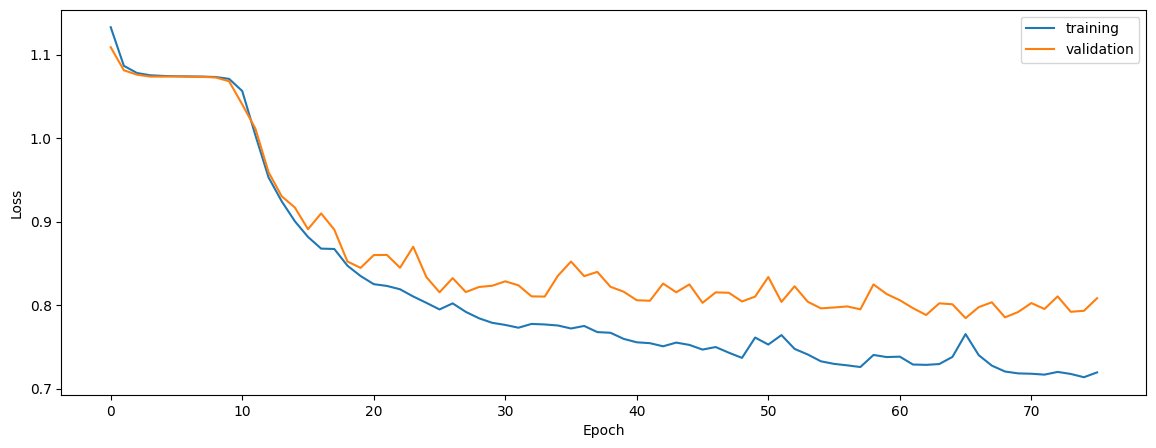

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6713943202158396


0.6549165120593692


0.6662468737251006


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.7391456416579721


0.6826602193012328


0.7139760647496944


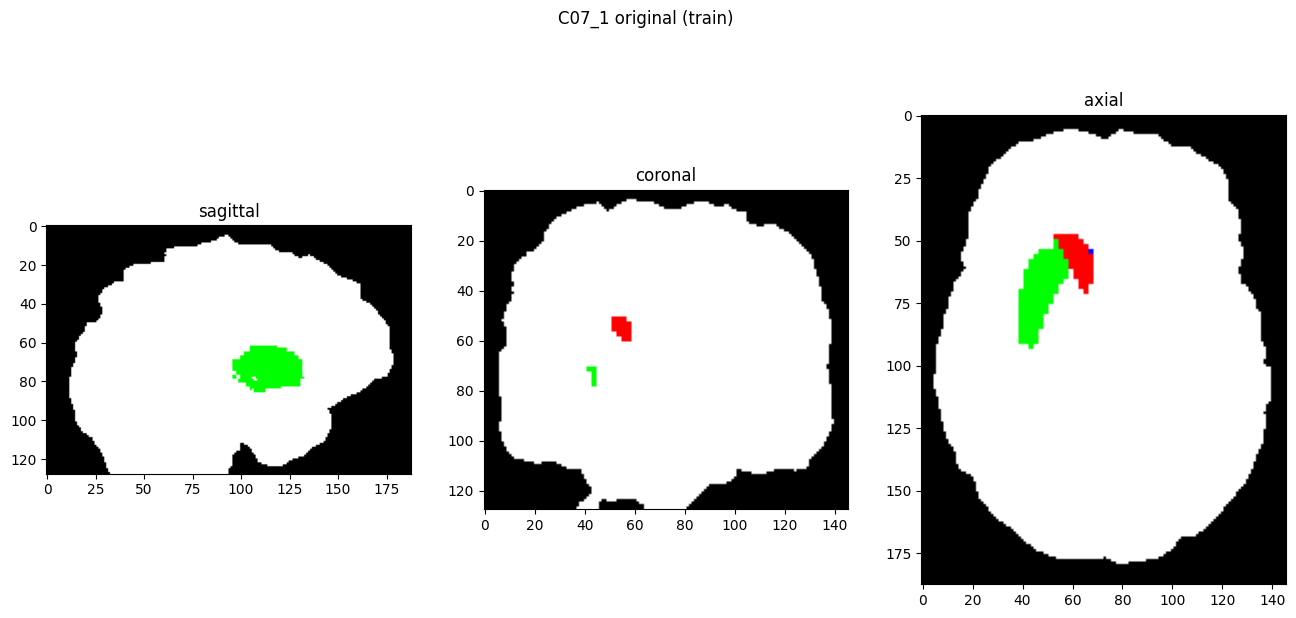

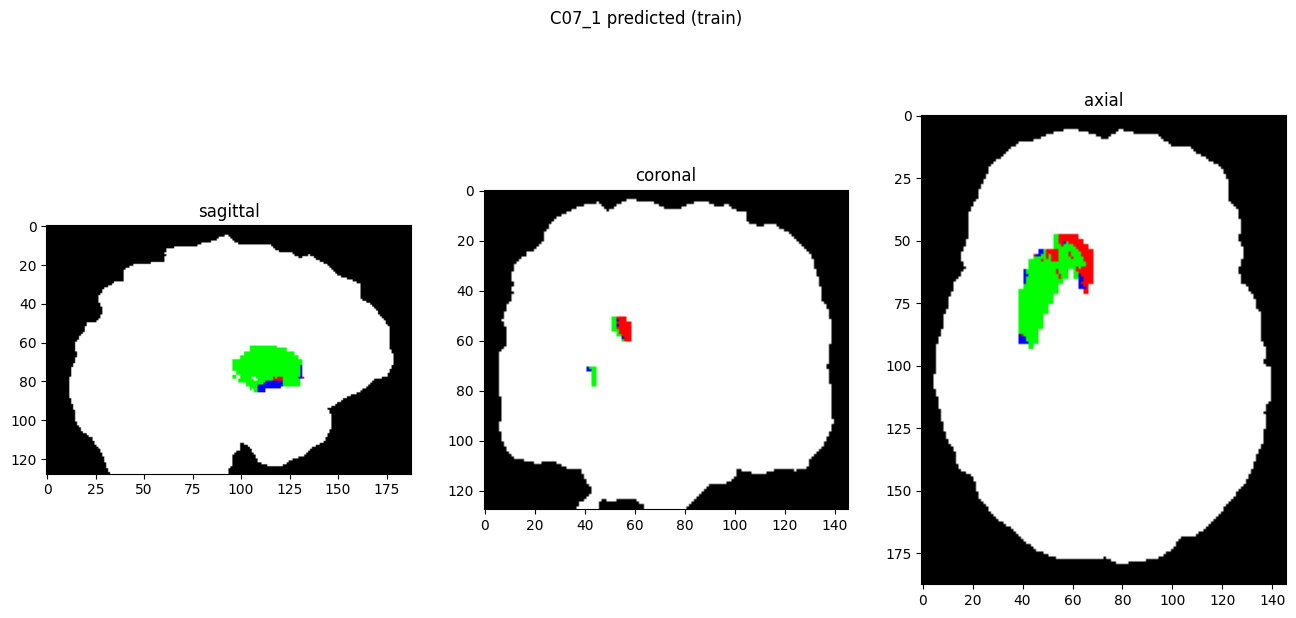

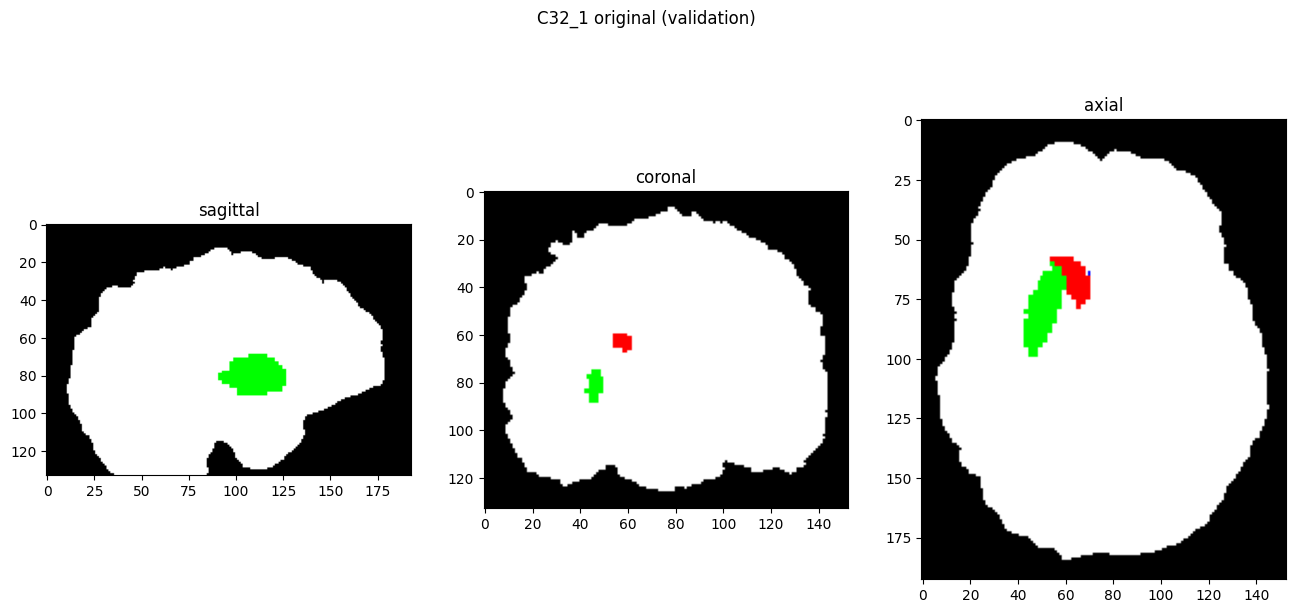

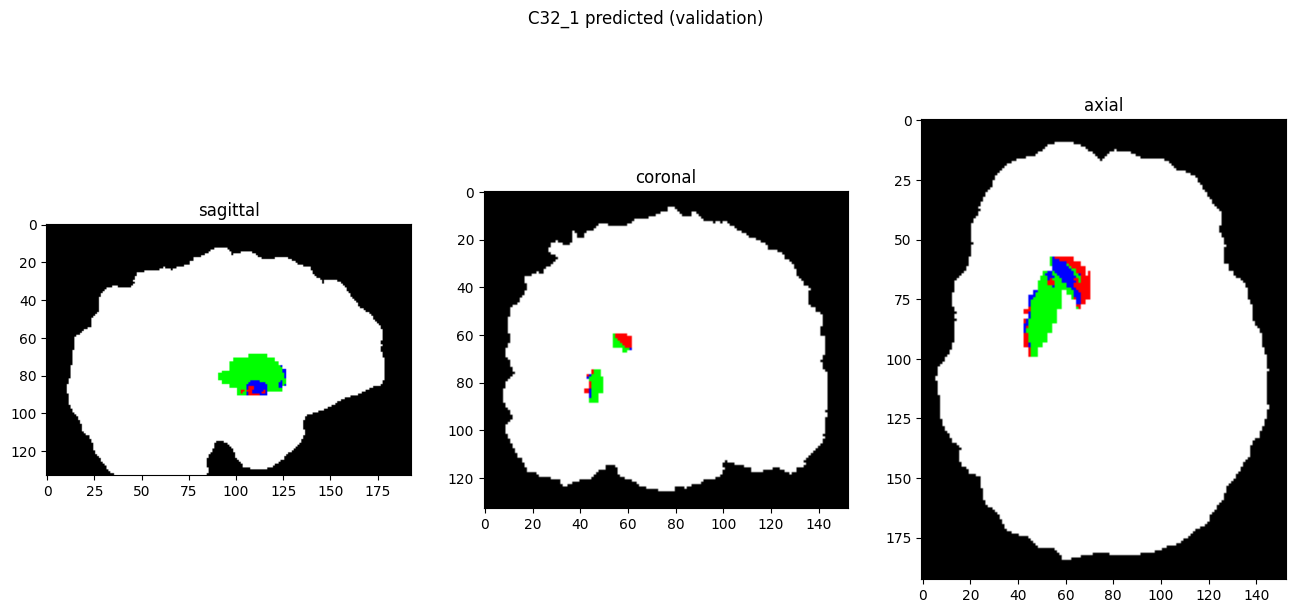

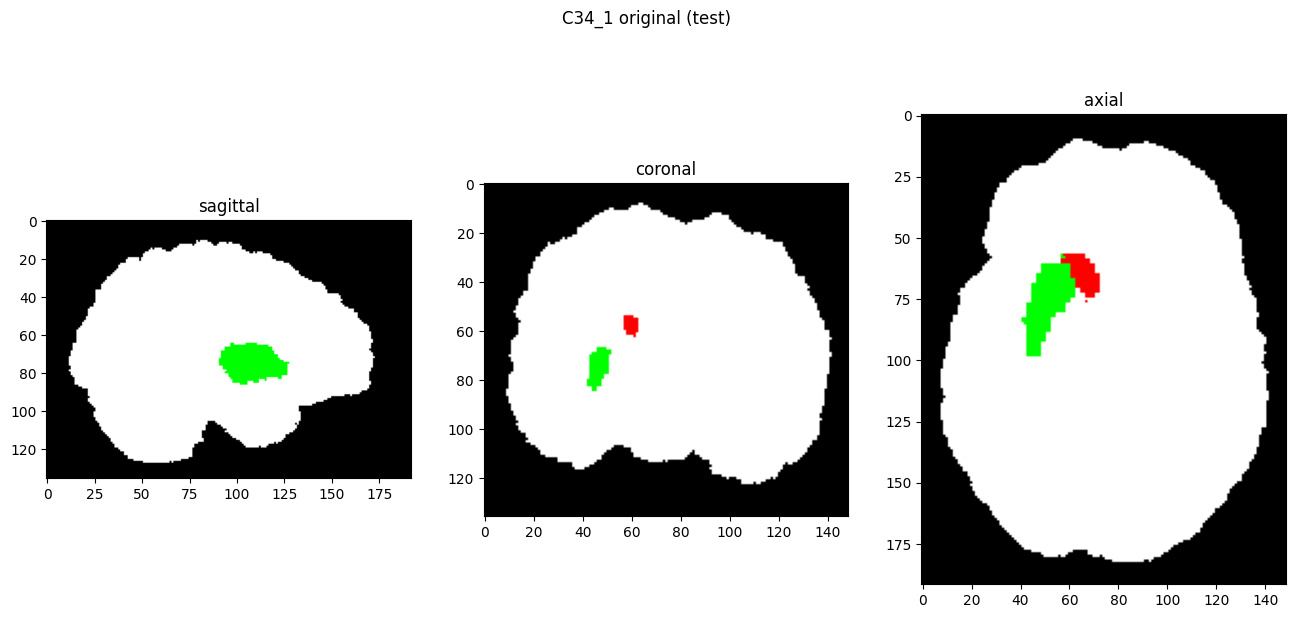

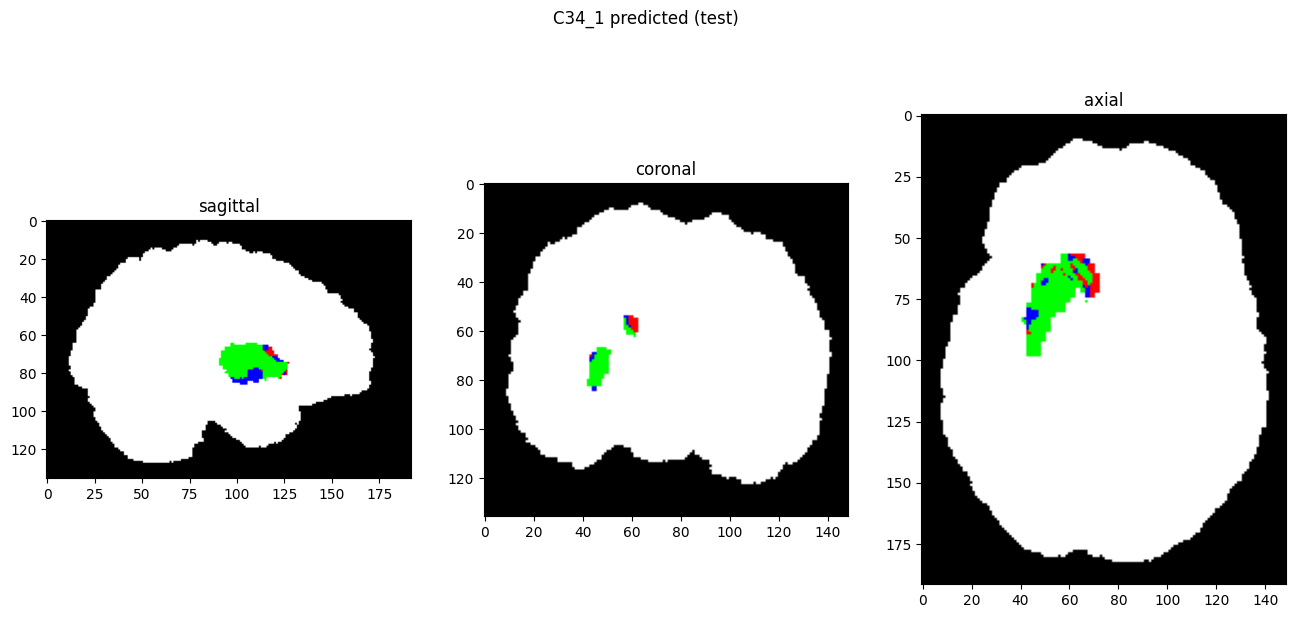

In [9]:
showResults(model, gen, threshold=0)